<a href="https://colab.research.google.com/github/sayan0506/Synthetic-Image-generation-using-VAE-/blob/main/Implement_VAE_using_Keras_backend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Modules

Importing nercessary modules, here we will implement the VAE using the tensorflow backend from scratch

In [37]:
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
# from keras.layers import BatchNormalization
# importing keras functional api for neural network 
from keras.models import Model
# in latest keras the datasets are corrspond to keras, rather than previous tensorflow.examples.tutorial
from keras.datasets import mnist
# this keras backend will help to do some basic calculations or math stuffs
from keras import backend as K
import numpy as np
from matplotlib import pyplot as plt

# Load MNIST

Loading the traina and test dataset of digits

In [43]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [44]:
print(f'Shape of the dataset: {x_train.shape}, {y_train.shape}, {x_test.shape}, {y_test.shape}')

Shape of the dataset: (60000, 28, 28), (60000,), (10000, 28, 28), (10000,)


# Data Pre-processing

## Normalizing the dataset

In [45]:
# as VAE is a autoencoder based network, no need of classification information
# so we will only deal with the images
# converting the pixels to float32
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

# normalizing the dataset
x_train = x_train / 255.
x_test = x_test / 255.

## Reshaping the dataset

In [46]:
# reshape the data
num_channels = 1
# reshaping the images to 4 dimensional space shape = (m, width, height, channels)
# skipped 1st 3 dimensions and adding new axis where we add channel axis
# for grayscale image channel = 1
x_train = x_train[:, :, :, np.newaxis]
x_test = x_test[:, :, :, np.newaxis]

# shape after reshaping
print(f'Reshaped size: {x_train.shape}, {x_test.shape}')

Reshaped size: (60000, 28, 28, 1), (10000, 28, 28, 1)


# Data Visualization

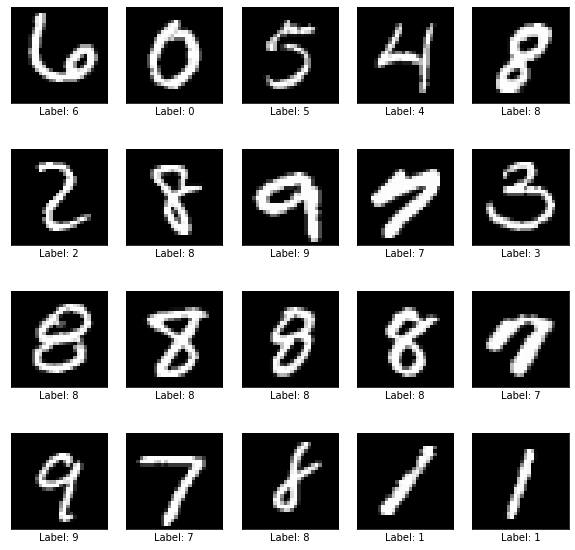

In [54]:
# let ius visualzie 20 random sample training images

# rows = 4
r = 4
# columns = 5
c = 5

fig = plt.figure(figsize=(10,10))

for i in range(r * c):
  fig.add_subplot(r, c, i + 1)
  # random image no
  img_id = np.random.randint(0, x_train.shape[0])
  # np.squeeze the all unimportant dimensions, here m = 1, c = 1 for single image
  plt.imshow(np.squeeze(x_train[img_id]), cmap = 'gray')
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(f'Label: {y_train[img_id]}')
  # plt.axis('off')

fig.show()